### <b> Apple Classifier </b> 

This notebook is a Deep Learning project  to train and deploy an image classifier using FastAI's API.

In [1]:
from fastbook import *
from fastai.vision.widgets import *

##### <b> 1. Gathering Data from the web </b>

In [2]:
apple_types = ['red', 'green', 'logo']
path = Path('apple')

In [ ]:
# Search for and download images
for a in apple_types:
    dest = (path/a)
    results = search_images_ddg(f'{a} apple images')
    for i, url in enumerate(results):
        try:
            download_url(url, dest / f'{a}{i}.jpg')
        except Exception as e:
            print(f"Error downloading {url}: {e}")

In [32]:
#Check download images to designated path
images = get_image_files(path)
images

(#583) [Path('apple/green/green0.jpg'),Path('apple/green/green1.jpg'),Path('apple/green/green10.jpg'),Path('apple/green/green100.jpg'),Path('apple/green/green101.jpg'),Path('apple/green/green102.jpg'),Path('apple/green/green103.jpg'),Path('apple/green/green104.jpg'),Path('apple/green/green106.jpg'),Path('apple/green/green107.jpg')...]

In [33]:
#Check number of images in each subfolder
def items_per_label(path, labels):
    dict =  {}
    for l in labels:
        dict[f'{l}'] = len(get_image_files(path/l))
    #print(dict)
    return dict

items_per_label(path, apple_types)

{'red': 193, 'green': 194, 'logo': 196}

In [1]:
get_image_files(path)

NameError: name 'get_image_files' is not defined

In [34]:
# Check for corrupt images
failed = verify_images(images)
failed

(#30) [Path('apple/green/green111.jpg'),Path('apple/green/green121.jpg'),Path('apple/green/green131.jpg'),Path('apple/green/green139.jpg'),Path('apple/green/green182.jpg'),Path('apple/green/green24.jpg'),Path('apple/green/green30.jpg'),Path('apple/green/green51.jpg'),Path('apple/green/green65.jpg'),Path('apple/green/green72.jpg')...]

In [35]:
#Remove corrupt images from directory
failed.map(Path.unlink)

(#30) [None,None,None,None,None,None,None,None,None,None...]

##### <b> 2. Data Loaders and Data Augmentation </b>

A DataLoader object allows you to store data and <b> split it into training and validation sets </b>.
<p> In this case, I'll use the <b> data block API </b> that is extremely flexible and customizable. </p>

In [36]:
apples = DataBlock(
    blocks=(ImageBlock,CategoryBlock), #defines the Independente and Dependent variables
    get_items=get_image_files, # asserts the types of data that will be used and fetches a list of all images it from a designated file path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #splits the dataset randomly into training (0.8) and validation (0.2)
    get_y=parent_label, #gets the labels from the name of the parent directory of the images
    item_tfms=Resize(128) #adjusts the images to a size of 128x128
)

In [37]:
#Create the DataLoader based on the previously defined DataBlock and path
dls = apples.dataloaders(path)

c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


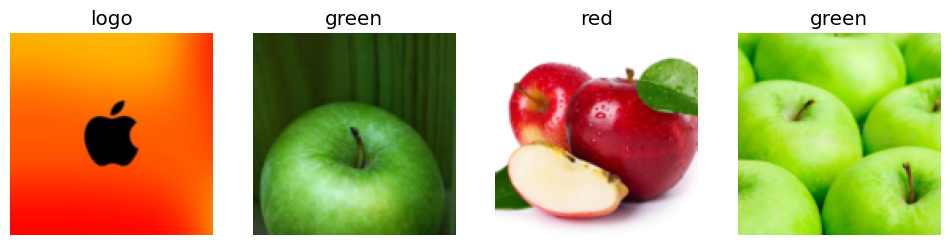

In [38]:
#Check a few items from the validation set
dls.valid.show_batch(max_n=4, nrows=1)

To prevent images from losing details when being resized to 128x128, we can alternatively <b> pad </b> the images or <b> squish/stretch</b> them.
<p> </p> In order to do so we can change the type of item transformation that is applied to the DataBlock:

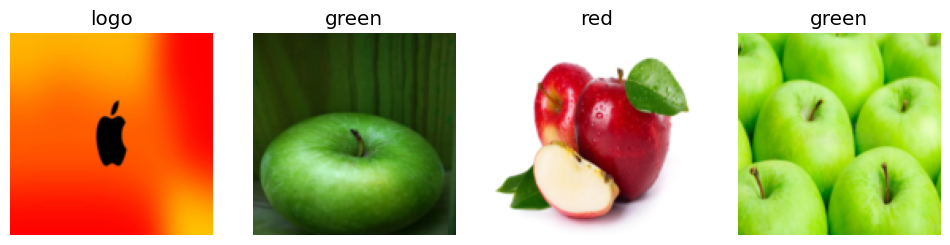

In [39]:
# Squishing transformation
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

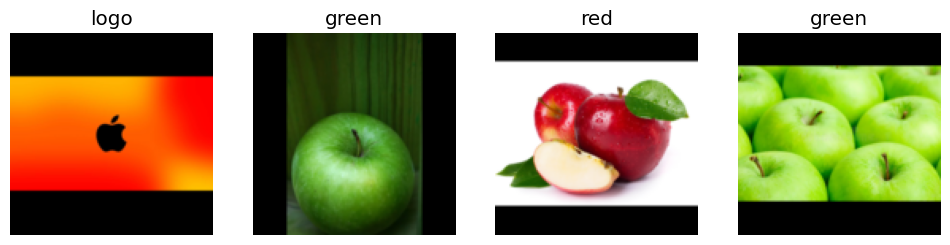

In [40]:
# Padding transformation
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

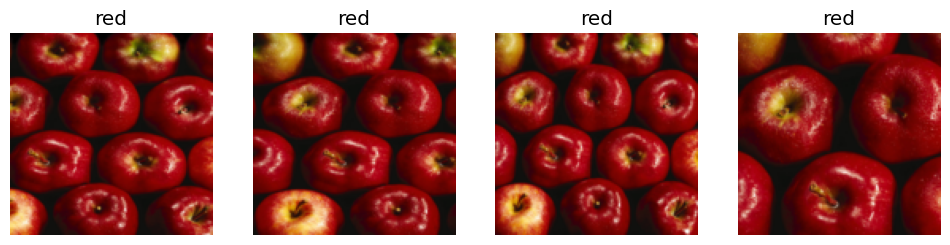

In [41]:
# Cropping the image at a minimum of 0.3 of the original image
apples = apples.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True) # Check for several transformation on the same image

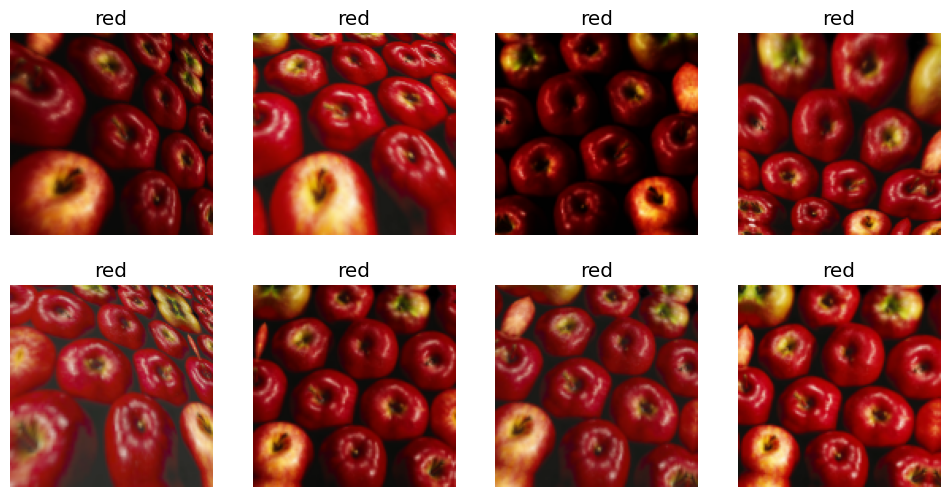

In [42]:
# More data augmentation using the aug-transforms function
apples = apples.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#### <b> 3. Training the Model and Cleaning the Data </b>

##### <b> 3.1.1. Before cleaning the dataset </b>

In [43]:
# Asserting the transformations applied to individual images and the augmentations applied to a batch in our DataLoad
apples = apples.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = apples.dataloaders(path)

Create the <code>Learner</code> and fine-tune it using <code> ResNet18</code>:

In [47]:
learner1 = vision_learner(dls, resnet18, metrics=error_rate)
learner1.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.660138,0.366687,0.127273,00:25


c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.568667,0.240898,0.100000,00:25
1,0.406592,0.161510,0.036364,00:26
2,0.321112,0.128555,0.036364,00:32
3,0.274919,0.131892,0.045455,00:35


c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


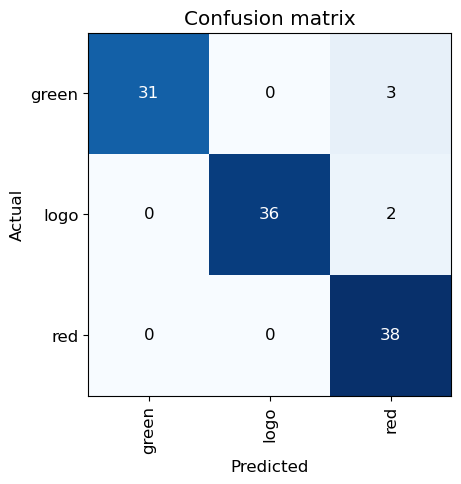

In [48]:
# Plotting confusion matrix to see how well the model is identifying apples
interp = ClassificationInterpretation.from_learner(learner1)
interp.plot_confusion_matrix()

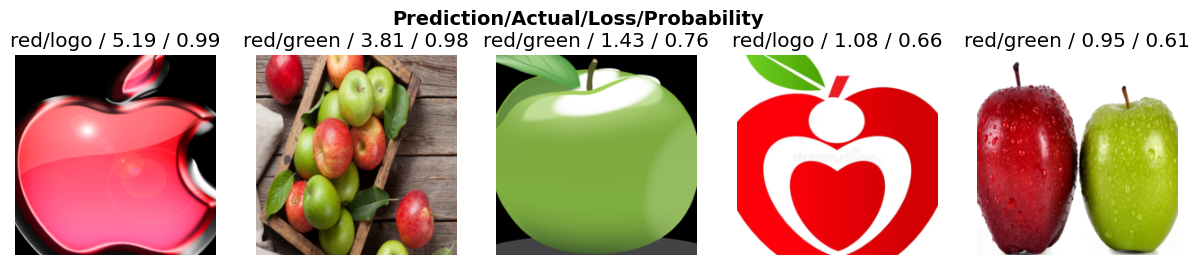

In [49]:
interp.plot_top_losses(5, nrows=1)

In [50]:
cleaner = ImageClassifierCleaner(learner1)
cleaner

c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [56]:
#These two lines of codes are meant to be ran after using the Clearner
for idx in cleaner.delete(): cleaner.fns[idx].unlink() #deletes unwanted pictures
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) #Moves misclassified pictures to the right folder

Since I saved the apple images in their respective directory based on the index of their position in the <code>results</code> array I couldn't make use of the <code>replace</code> functionality in the <code>ImageClassifierCleaner</code> since I would get an error when swapping images to their correct label folder.

<p> Swapping the image in folder apple/red/1.jpg to apple/green/1.jpg would yield an error since there already is a apple/green/1.jpg file.</p>
<p> I will correct this later on saving the images based on the urls of the DuckDuckGo search.</p>

##### <b> 3.1.2. After cleaning the dataset </b>

In [57]:
# Update image directory in the dala loader
dls = apples.dataloaders(path)

c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [59]:
learner1 = vision_learner(dls, resnet18, metrics=error_rate)
learner1.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.605719,0.325471,0.095238,00:24


c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.415469,0.105619,0.028571,00:24
1,0.281002,0.028308,0.009524,00:24
2,0.213823,0.012475,0.000000,00:24
3,0.178931,0.011339,0.000000,00:24


<b> After cleaning the dataset we achieve an error rate of 0% ! </b>

c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


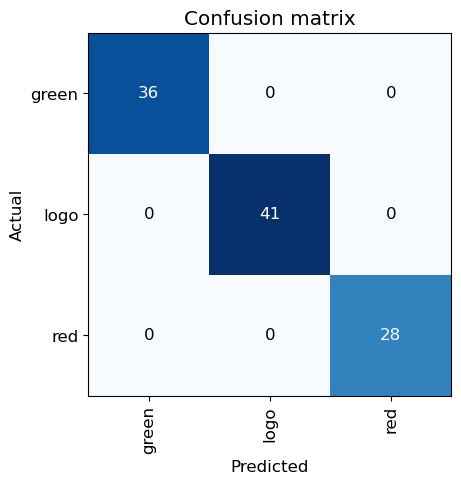

In [60]:
interp = ClassificationInterpretation.from_learner(learner1)
interp.plot_confusion_matrix()

<b> As we can now see all of the pictures are being correctly classified </b>

#### <b> 4. Turning the Model into an Online App </b>

In [62]:
# The .export method saves both the architecture and the trained parameters in a .pkl file
# It also saves the definition of how to create the DataLoader
learner1.export()

In [63]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]